# Day-Ahead Market Prices: Data Exploration

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

## 1. Read & preprocess the data

In [2]:
df = pd.read_csv('../data/processed/day_ahead_prices/hub_prices.csv')

In [3]:
df.head()

,Date,01,02,03,04,05,06,07,08,09,...,16,17,18,19,20,21,22,23,24,02X
0,2023-11-01,33.07,31.23,31.83,31.32,32.04,33.72,44.28,62.78,55.60,...,42.93,43.58,60.36,85.72,60.00,47.54,42.82,42.43,36.51,NaN
1,2023-11-02,29.10,28.13,26.12,26.85,28.36,33.73,53.82,67.46,54.94,...,30.47,35.00,50.34,53.54,52.82,35.36,33.71,31.84,31.41,NaN
2,2023-11-03,24.50,25.19,24.24,24.26,25.77,32.97,44.20,59.75,48.96,...,24.05,29.84,34.75,35.75,30.71,32.62,30.80,27.17,24.09,NaN
3,2023-11-06,16.77,16.68,17.17,16.86,17.83,27.50,37.18,52.74,37.47,...,36.63,47.00,68.80,35.24,27.54,28.15,29.88,26.01,22.15,NaN
4,2023-11-07,29.34,23.10,21.80,21.46,20.65,26.38,35.13,35.43,32.10,...,28.37,41.16,53.29,34.56,28.14,27.33,24.28,21.52,20.27,NaN


In [4]:
hour_columns = [str(i) if i > 9 else '0'+str(i) for i in range(1, 25)]
X = df[hour_columns].values

## 2. Day-ahead time series

### Select one day and plot it

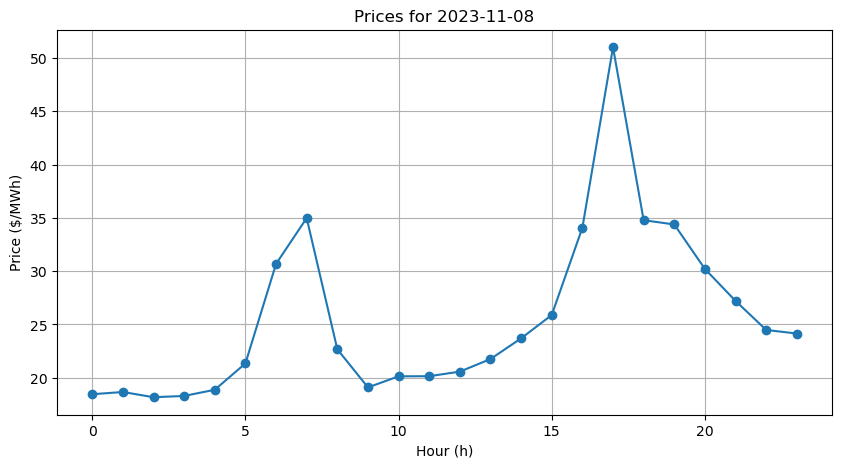

In [5]:
# Select a day by index
day_index = 5
selected_day_prices = X[day_index]

# Plot the prices
plt.figure(figsize=(10, 5))
plt.plot(range(24), selected_day_prices, marker='o')
plt.title(f"Prices for {df.iloc[day_index]['Date']}")
plt.xlabel('Hour (h)')
plt.ylabel('Price ($/MWh)')
plt.grid(True)
plt.show()

### Plot all days together

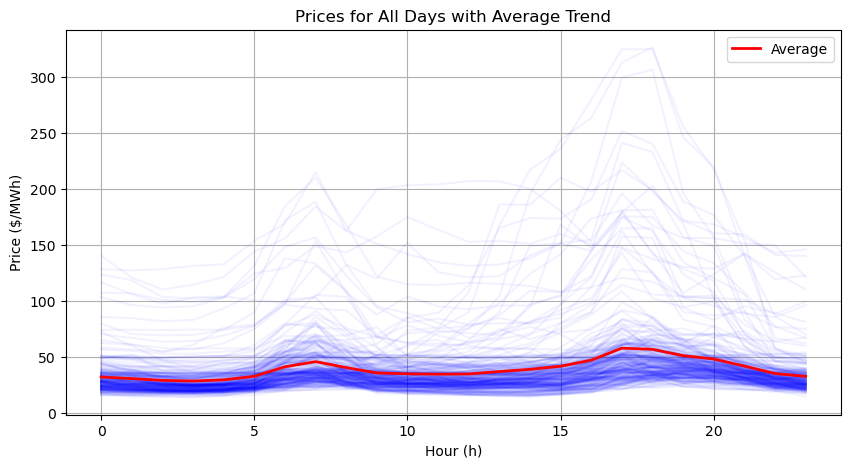

In [6]:
import matplotlib.pyplot as plt

# Plot prices for all days with transparency
plt.figure(figsize=(10, 5))

num_days = X.shape[0]

for day_index in range(num_days):
    selected_day_prices = X[day_index]
    plt.plot(range(24), selected_day_prices, color='blue', alpha=0.05)

# Compute and plot the mean prices
mean_prices = X.mean(axis=0)
plt.plot(range(24), mean_prices, color='red', linewidth=2, label='Average')

plt.title("Prices for All Days with Average Trend")
plt.xlabel('Hour (h)')
plt.ylabel('Price ($/MWh)')
plt.grid(True)
plt.legend()
plt.show()

## 3. Dimensionality reduction & clustering

### Standardize and perform PCA

In [7]:
# Standardize the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Determine number of components to explain at least 90% variance
cum_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cum_variance >= 0.9) + 1

print(f'Number of components explaining at least 90% of the variance: {n_components}')

Number of components explaining at least 90% of the variance: 2


### Project data onto principal components

In [8]:
# Project data onto selected principal components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

### K-means clustering with cross-validation

Best number of clusters: 2


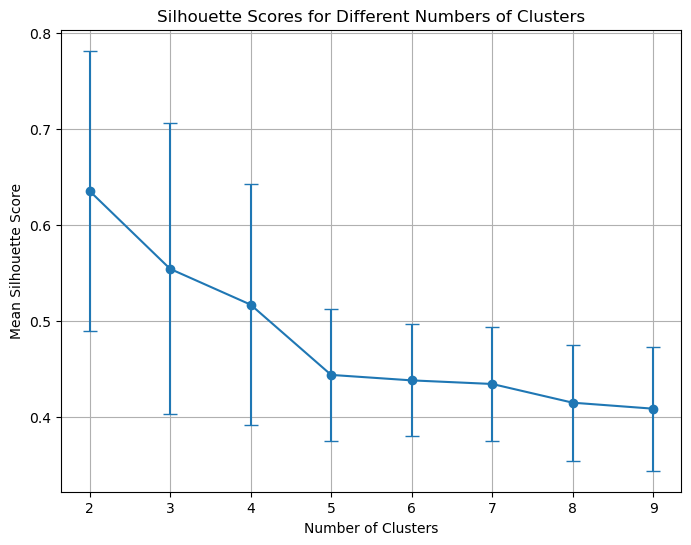

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from threadpoolctl import threadpool_limits
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Define a pipeline
pipeline = Pipeline([
    ('kmeans', KMeans(random_state=42))
])

# Define parameter grid to search over number of clusters
param_grid = {
    'kmeans__n_clusters': range(2, 10)
}

# Use silhouette score as the metric
def silhouette_scorer(estimator, X):
    clusters = estimator.fit_predict(X)
    score = silhouette_score(X, clusters)
    return score

grid_search = GridSearchCV(pipeline, param_grid, scoring=silhouette_scorer, cv=5, n_jobs=1)

# Limit the number of threads to 1 during fit
with threadpool_limits(limits=1):
    grid_search.fit(X_pca)

print(f"Best number of clusters: {grid_search.best_params_['kmeans__n_clusters']}")

# Extract the silhouette scores
results = grid_search.cv_results_
n_clusters = np.array([int(n) for n in results['param_kmeans__n_clusters']])
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.errorbar(n_clusters, mean_scores, yerr=std_scores, fmt='o-', capsize=5)
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(n_clusters)
plt.grid(True)
plt.show()

### Perform K-means clustering with the optimal number of clusters

In [10]:
# Perform K-means clustering with the optimal number of clusters
best_k = grid_search.best_params_['kmeans__n_clusters']
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X_pca)

c:\Users\sabri\miniconda3\envs\v2g\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### Visualize clustering in projected space using t-SNE

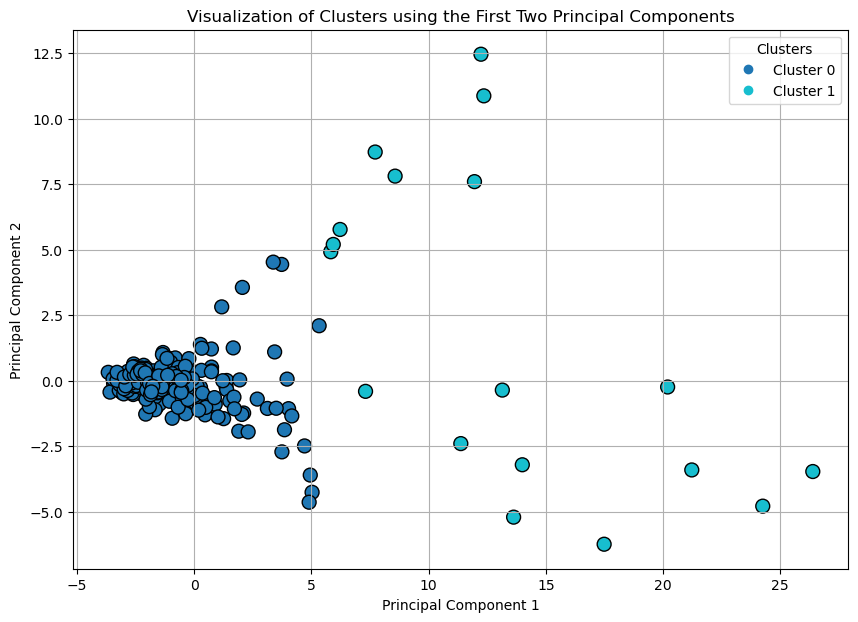

In [11]:
# Visualize clustering using the first two principal components

if X_pca.shape[1] >= 2:
    X_pca_2d = X_pca[:, :2]
else:
    # Perform PCA again with n_components=2 for visualization purposes
    pca_visual = PCA(n_components=2)
    X_pca_2d = pca_visual.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters, cmap='tab10', s=100, edgecolors='k')
handles, _ = scatter.legend_elements()
labels = [f'Cluster {i}' for i in range(best_k)]
plt.legend(handles, labels, title="Clusters")
plt.title('Visualization of Clusters using the First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

### Compute and plot mean time series for each cluster

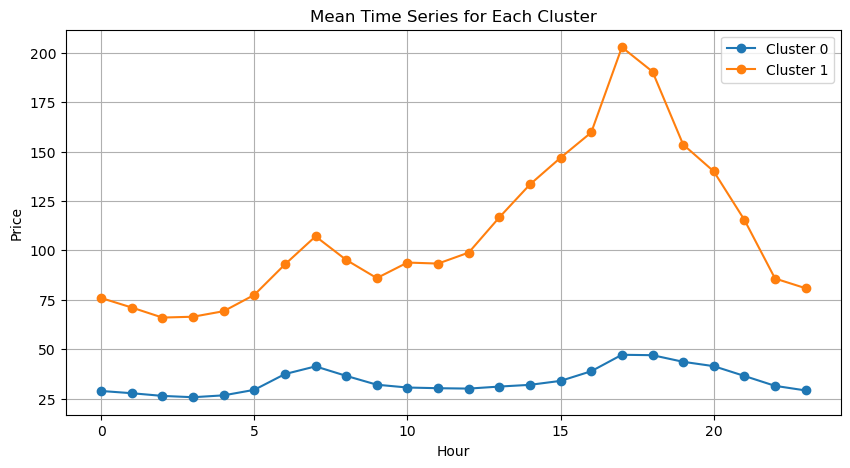

In [12]:
# Compute mean time series for each cluster
cluster_labels = clusters
cluster_centers = []

for k in range(best_k):
    cluster_data = X[cluster_labels == k]
    mean_time_series = cluster_data.mean(axis=0)
    cluster_centers.append(mean_time_series)

# Plot mean time series for each cluster on the same plot with different colors
plt.figure(figsize=(10, 5))

for idx, mean_ts in enumerate(cluster_centers):
    plt.plot(range(24), mean_ts, marker='o', label=f'Cluster {idx}')

plt.title('Mean Time Series for Each Cluster')
plt.xlabel('Hour')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

### Sample a date from a specific cluster

In [16]:
# Set the cluster number to list dates from
cluster_number = 1  # Change this to list dates from a different cluster

# Get the indices of all days belonging to the specified cluster
cluster_indices = np.where(cluster_labels == cluster_number)[0]

# Ensure the cluster is not empty
if len(cluster_indices) == 0:
    print(f"Cluster {cluster_number} is empty. Please choose another cluster.")
else:
    # Get all dates corresponding to the specified cluster
    cluster_dates = df.iloc[cluster_indices]['Date'].tolist()
    
    print(f"All dates from Cluster {cluster_number}: {cluster_dates}")

All dates from Cluster 1: [Timestamp('2023-11-29 00:00:00'), Timestamp('2023-12-06 00:00:00'), Timestamp('2023-12-07 00:00:00'), Timestamp('2024-01-15 00:00:00'), Timestamp('2024-01-16 00:00:00'), Timestamp('2024-01-17 00:00:00'), Timestamp('2024-01-18 00:00:00'), Timestamp('2024-01-19 00:00:00'), Timestamp('2024-01-22 00:00:00'), Timestamp('2024-01-30 00:00:00'), Timestamp('2024-06-19 00:00:00'), Timestamp('2024-06-20 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-08-01 00:00:00'), Timestamp('2024-08-02 00:00:00')]


### Plot nb of days in each cluster for every month of the year

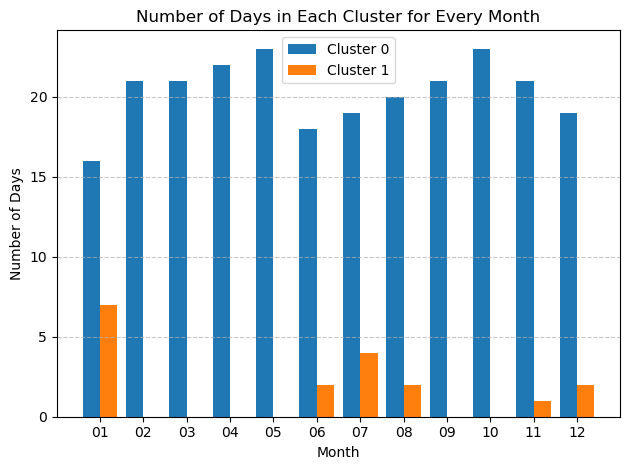

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure the 'Date' column is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Add cluster labels to the DataFrame for easy grouping
df['Cluster'] = cluster_labels

# Extract month and year for grouping
df['Month'] = df['Date'].dt.month

# Group by month and cluster to count days
monthly_cluster_counts = df.groupby(['Month', 'Cluster']).size().unstack(fill_value=0)

# Ensure all months are present
months = np.arange(1, 13)
cluster_0_counts = [monthly_cluster_counts.loc[m, 0] if m in monthly_cluster_counts.index else 0 for m in months]
cluster_1_counts = [monthly_cluster_counts.loc[m, 1] if m in monthly_cluster_counts.index else 0 for m in months]

# Plot the bar chart
bar_width = 0.4
plt.bar(months - bar_width / 2, cluster_0_counts, bar_width, label="Cluster 0")
plt.bar(months + bar_width / 2, cluster_1_counts, bar_width, label="Cluster 1")

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Number of Days')
plt.title('Number of Days in Each Cluster for Every Month')
plt.xticks(months, [f'{m:02d}' for m in months])  # Format months as two digits
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()